In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# styling constants
matplotlib.rcParams.update({'font.family': 'monospace'})

# some styling constants
PURPLE = '#6935FF'
GREEN = '#3A4934'
WHITE = '#FAF7F3'
SMALL = 10

# date constants
START = '2018Q1'
END = '2023Q4'

In [3]:
project_names = pd.read_json("data/gitcoin-project-names.json").set_index('slug')['name'].to_dict()

# Overall grants analysis

In [4]:
g = pd.read_csv("data/csv/gitcoin_allo+cgrants_all.csv", index_col=0)

# load and arrange the funding round data
g['quarter'] = pd.PeriodIndex(g.round_date, freq='Q')
g['quarter'] = g['quarter'].apply(str)

def name_round(rid, rname):
    if '0x' in rid:
        return rname
    else:
        return f"GR{rid}"
g['round'] = g.apply(lambda x: name_round(x['round_id'], x['round_name']), axis=1)

# manual updates to clean a few rounds that are on the edge of a quarter
g.loc[g['round'] == 'GR2', 'quarter'] = '2019Q2'
g.loc[g['round'] == 'GR4', 'quarter'] = '2019Q4'

# rename allo grants
g.loc[g['quarter'] == '2023Q1', 'round'] = 'Alpha'
g.loc[g['quarter'] == '2023Q2', 'round'] = 'Beta'
g.loc[g['quarter'] == '2023Q3', 'round'] = 'GG18'
g.loc[g['quarter'] == '2023Q4', 'round'] = 'GG19'

g.head(1)

,project_name,project_github,oso_github_slug,grant_address,oso_address_slug,round_id,round_name,chain_id,program_address,round_date,amount_usd,match_usd,total_usd,oso_slug,quarter,round
0,Crypto Sapiens,NaN,NaN,0x01999e431752136372a3d485f527907a6b02a1d1,NaN,0x2871742b184633f8dc8546c6301cbc209945033e,Web3 Community and Education,10.0,0xa1e8c5a8ca033ac3cb738506c6f1ad15bf54a730,2023-08-15 08:00:00,197.889151,598.929745,796.818896,NaN,2023Q3,GG18


In [5]:
print("Total ($M):", g['total_usd'].sum() / 1_000_000)
print("Matching pools ($M):", g['match_usd'].sum() / 1_000_000)
multiplier = g['total_usd'].sum()/g['match_usd'].sum()
print("Multiplier:", multiplier)
print("Applications:", len(g))
print("Est projects:", len(g['grant_address'].unique()))

Total ($M): 38.18401334814828
Matching pools ($M): 21.725962283018458
Multiplier: 1.7575292109382807
Applications: 18869
Est projects: 4724


## Four phases of grants

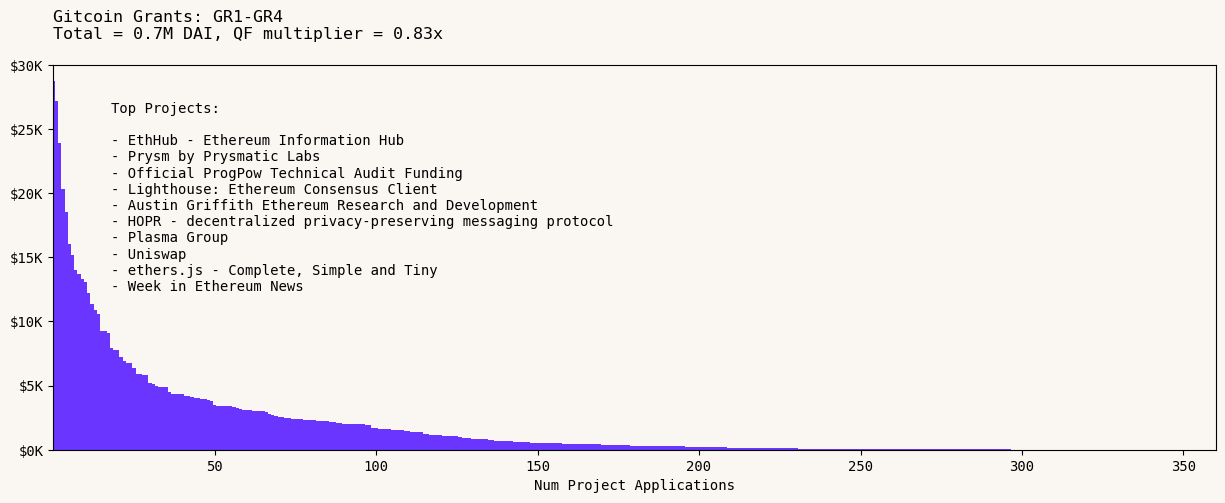

In [6]:
COLOR = PURPLE

def phase_chart(dataframe):
    
    dff = (
        dataframe[['project_name', 'amount_usd', 'match_usd', 'total_usd', 'round']]
        .dropna()
        .sort_values(by='total_usd', ascending=False)
    )
    
    n = len(dff['total_usd'])
    total = dff['total_usd'].sum() / 1_000_000
    max_y = dff['total_usd'].iloc[1:].max()
    
    qf = dff[dff['match_usd'] > 0]['match_usd'].sum()
    rf = dff[dff['match_usd'] > 0]['amount_usd'].sum()
    multiple = rf / qf
    
    round_names = sorted(dff['round'].unique())
    title = f'Gitcoin Grants: {round_names[0]}-{round_names[-1]}'
    title += f'\nTotal = {total:,.1f}M DAI, QF multiplier = {multiple:,.2f}x\n'
    
    fig, ax = plt.subplots(figsize=(15,5), facecolor=WHITE)
    (dff['total_usd']/1000).plot(kind='bar', lw=0, color=COLOR, edgecolor=COLOR, width=1)
    
    ax.set_xlim(0, n)
    
    step = 10 ** int(np.log10(n))
    if n / step < 5:
        step = int(step/2) 
        
    xticks = [x for x in range(step, n, step)]
    ax.set_xticks(xticks, xticks, rotation=0)
    ax.set_xlabel("Num Project Applications")
    
    ax.set_ylim(0, max_y/1000)
    yticks = ax.get_yticks()
    ylabels = [f'${y.get_text()}K' for y in ax.get_yticklabels()] 
    ax.set_yticks(yticks, labels=ylabels)
    ax.set_title(title, loc='left')
    
    short_tail = dff[dff['match_usd'] > 0].groupby('project_name')['total_usd'].sum().sort_values(ascending=False).head(10)
    projects = "Top Projects:\n\n" + "\n".join([f"- {p}" for p in short_tail.index.unique()])
    ax.text(s=projects, x=n*.05, y=max_y/1000, va='top')
    ax.set_facecolor(WHITE)
    
phase_chart(g[g['quarter'] < '2020Q1'])

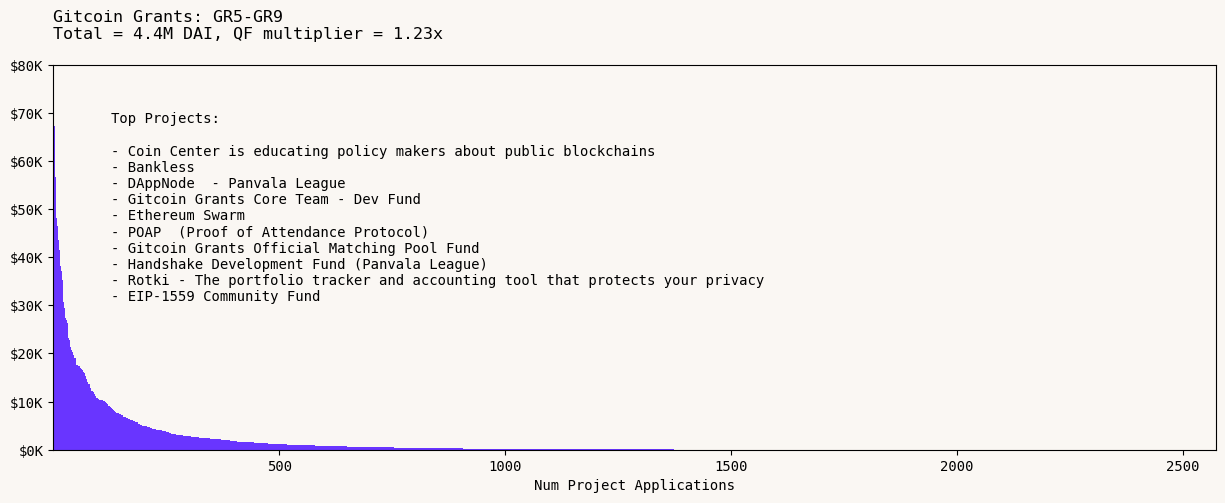

In [7]:
phase_chart(g[(g['quarter'] >= '2020Q1') & (g['quarter'] < '2021Q2')])

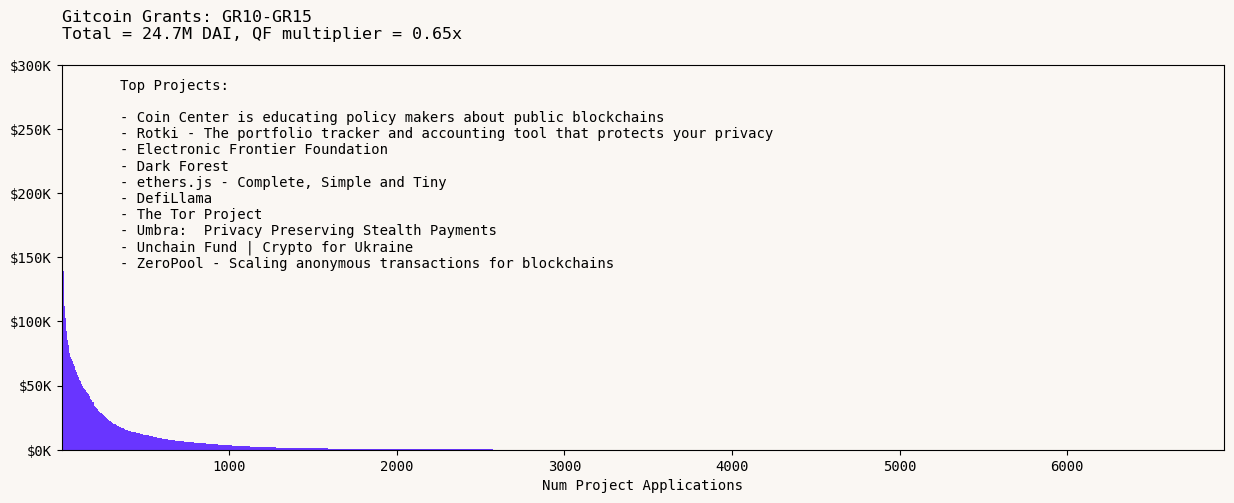

In [8]:
phase_chart(g[(g['quarter'] >= '2021Q2') & (g['quarter'] < '2023Q1')])

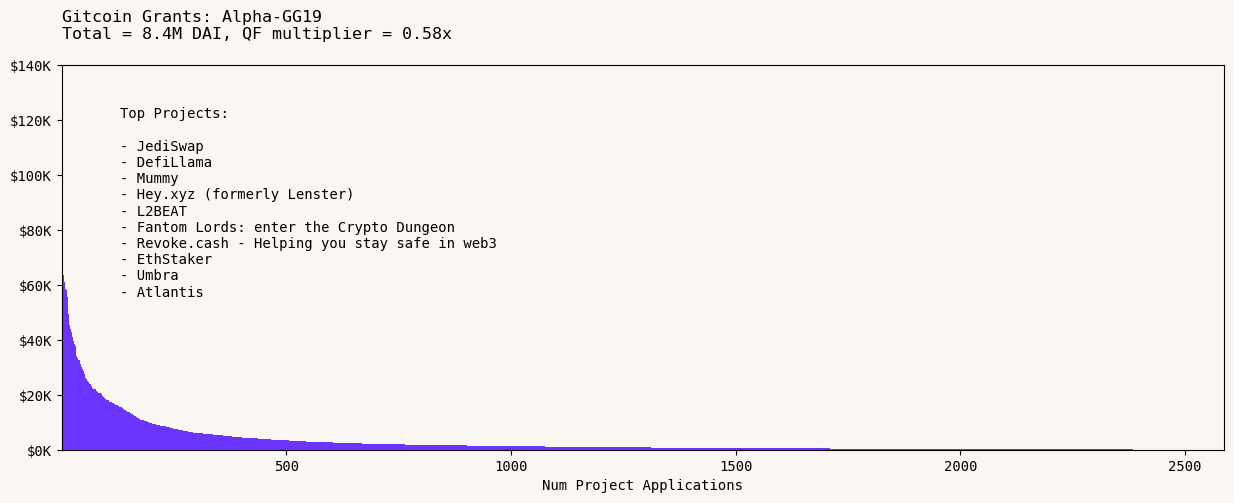

In [9]:
phase_chart(g[(g['quarter'] >= '2023Q1') & (g['quarter'] < '2024Q1')])

# Incorporate OSS Impact Data

In [10]:
# load and arrange the impact metrics
impact = (
    pd.read_csv("data/csv/gitcoin_active_devs_impact_by_quarter.csv", index_col=0)
    .set_index(['project_slug', 'quarter'])
    .join(
        pd.read_csv("data/csv/gitcoin_contributor_impact_by_quarter.csv", index_col=0)
        .groupby(['project_slug', 'quarter'])
        ['from_name']
        .nunique()
        .rename('contributors')
    )
    .reset_index()
)
impact = impact[
    (impact['project_slug'] != 'gitcoin') 
    & (impact['quarter'] >= START) 
    & (impact['quarter'] <= END)
]

# filter on the top 50 OSS projects
top50_oss_slugs = (    
    impact
    .groupby('project_slug')
    ['contributors']
    .max()
    .sort_values()
    .tail(50)
    .index
    .to_list()
)
impact = impact[impact['project_slug'].isin(top50_oss_slugs)]
impact.head(2)

,project_slug,quarter,full-time,part-time,contributors
0,4everland,2021Q2,0,2,2
1,4everland,2021Q3,2,2,9


In [11]:
# filter on the relevants grants data
grants = g.copy()
grants = grants[['oso_slug', 'round_id', 'round_name', 'quarter', 'round', 'round_date', 'total_usd']]
grants = grants[grants['oso_slug'].isin(top50_oss_slugs)]
grants.head(1)

,oso_slug,round_id,round_name,quarter,round,round_date,total_usd
18,l2beat,0x222ea76664ed77d18d4416d2b2e77937b76f0a35,Ethereum Infrastructure,2023Q3,GG18,2023-08-15 08:00:00,30127.21813


In [12]:
# get ROI figures

oss_grants = grants['total_usd'].sum()
oss_devs = impact[impact['quarter'] == '2023Q4']['full-time'].sum()
print("Cum. grants to top 50 OSS ($M):", oss_grants/1_000_000)
print("Full-time developers at top 50 OSS (2023Q4):", oss_devs)
roi = oss_devs/oss_grants*1_000_000
print("$1M in grants gets __ full-time devs:", roi)
print("... with crowdfunding multiplier:", roi*multiplier)

Cum. grants to top 50 OSS ($M): 9.280884675668773
Full-time developers at top 50 OSS (2023Q4): 69
$1M in grants gets __ full-time devs: 7.434636073099133
... with crowdfunding multiplier: 13.066590071167198


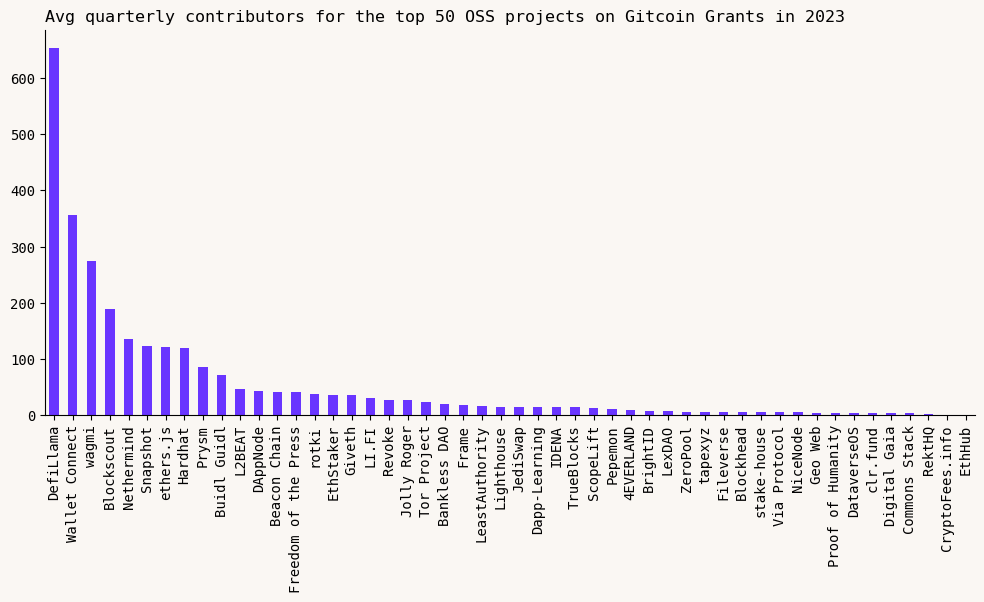

In [13]:
# show the breakdown by project

fig, ax = plt.subplots(figsize=(12,5), facecolor=WHITE)

(
    impact
    .pivot_table(index='project_slug', columns='quarter', values='contributors')
    .iloc[:,-4:]
    .fillna(0)
    .mean(axis=1)
    .sort_values(ascending=False)
    .rename(index=project_names)
).plot(kind='bar', color=PURPLE, ax=ax)
ax.set_facecolor(WHITE)
ax.set_xlabel("")
ax.set_title("Avg quarterly contributors for the top 50 OSS projects on Gitcoin Grants in 2023", loc='left')
sns.despine()

## Make THE Graph

In [14]:
# have some quarterly stats ready to help with the plotting
 
grant_stats = grants.groupby(['quarter', 'round'])['total_usd'].sum()

quarters = sorted(impact['quarter'].unique())
quarter_mapping = dict(zip(quarters, range(len(quarters))))

projects_first_rounds = (
    grants
    .groupby(['oso_slug'])
    ['quarter']
    .min()
    .reset_index()
    .groupby('quarter')
    ['oso_slug']
    .agg(lambda x: sorted(x))
)
ordered_projects_list = [p for lst in projects_first_rounds for p in lst]
projects_first_rounds.head(2)

quarter
2019Q1    [ethers-io, ethhub-io, lighthouse-sigp, prysma...
2019Q2                                      [walletconnect]
Name: oso_slug, dtype: object

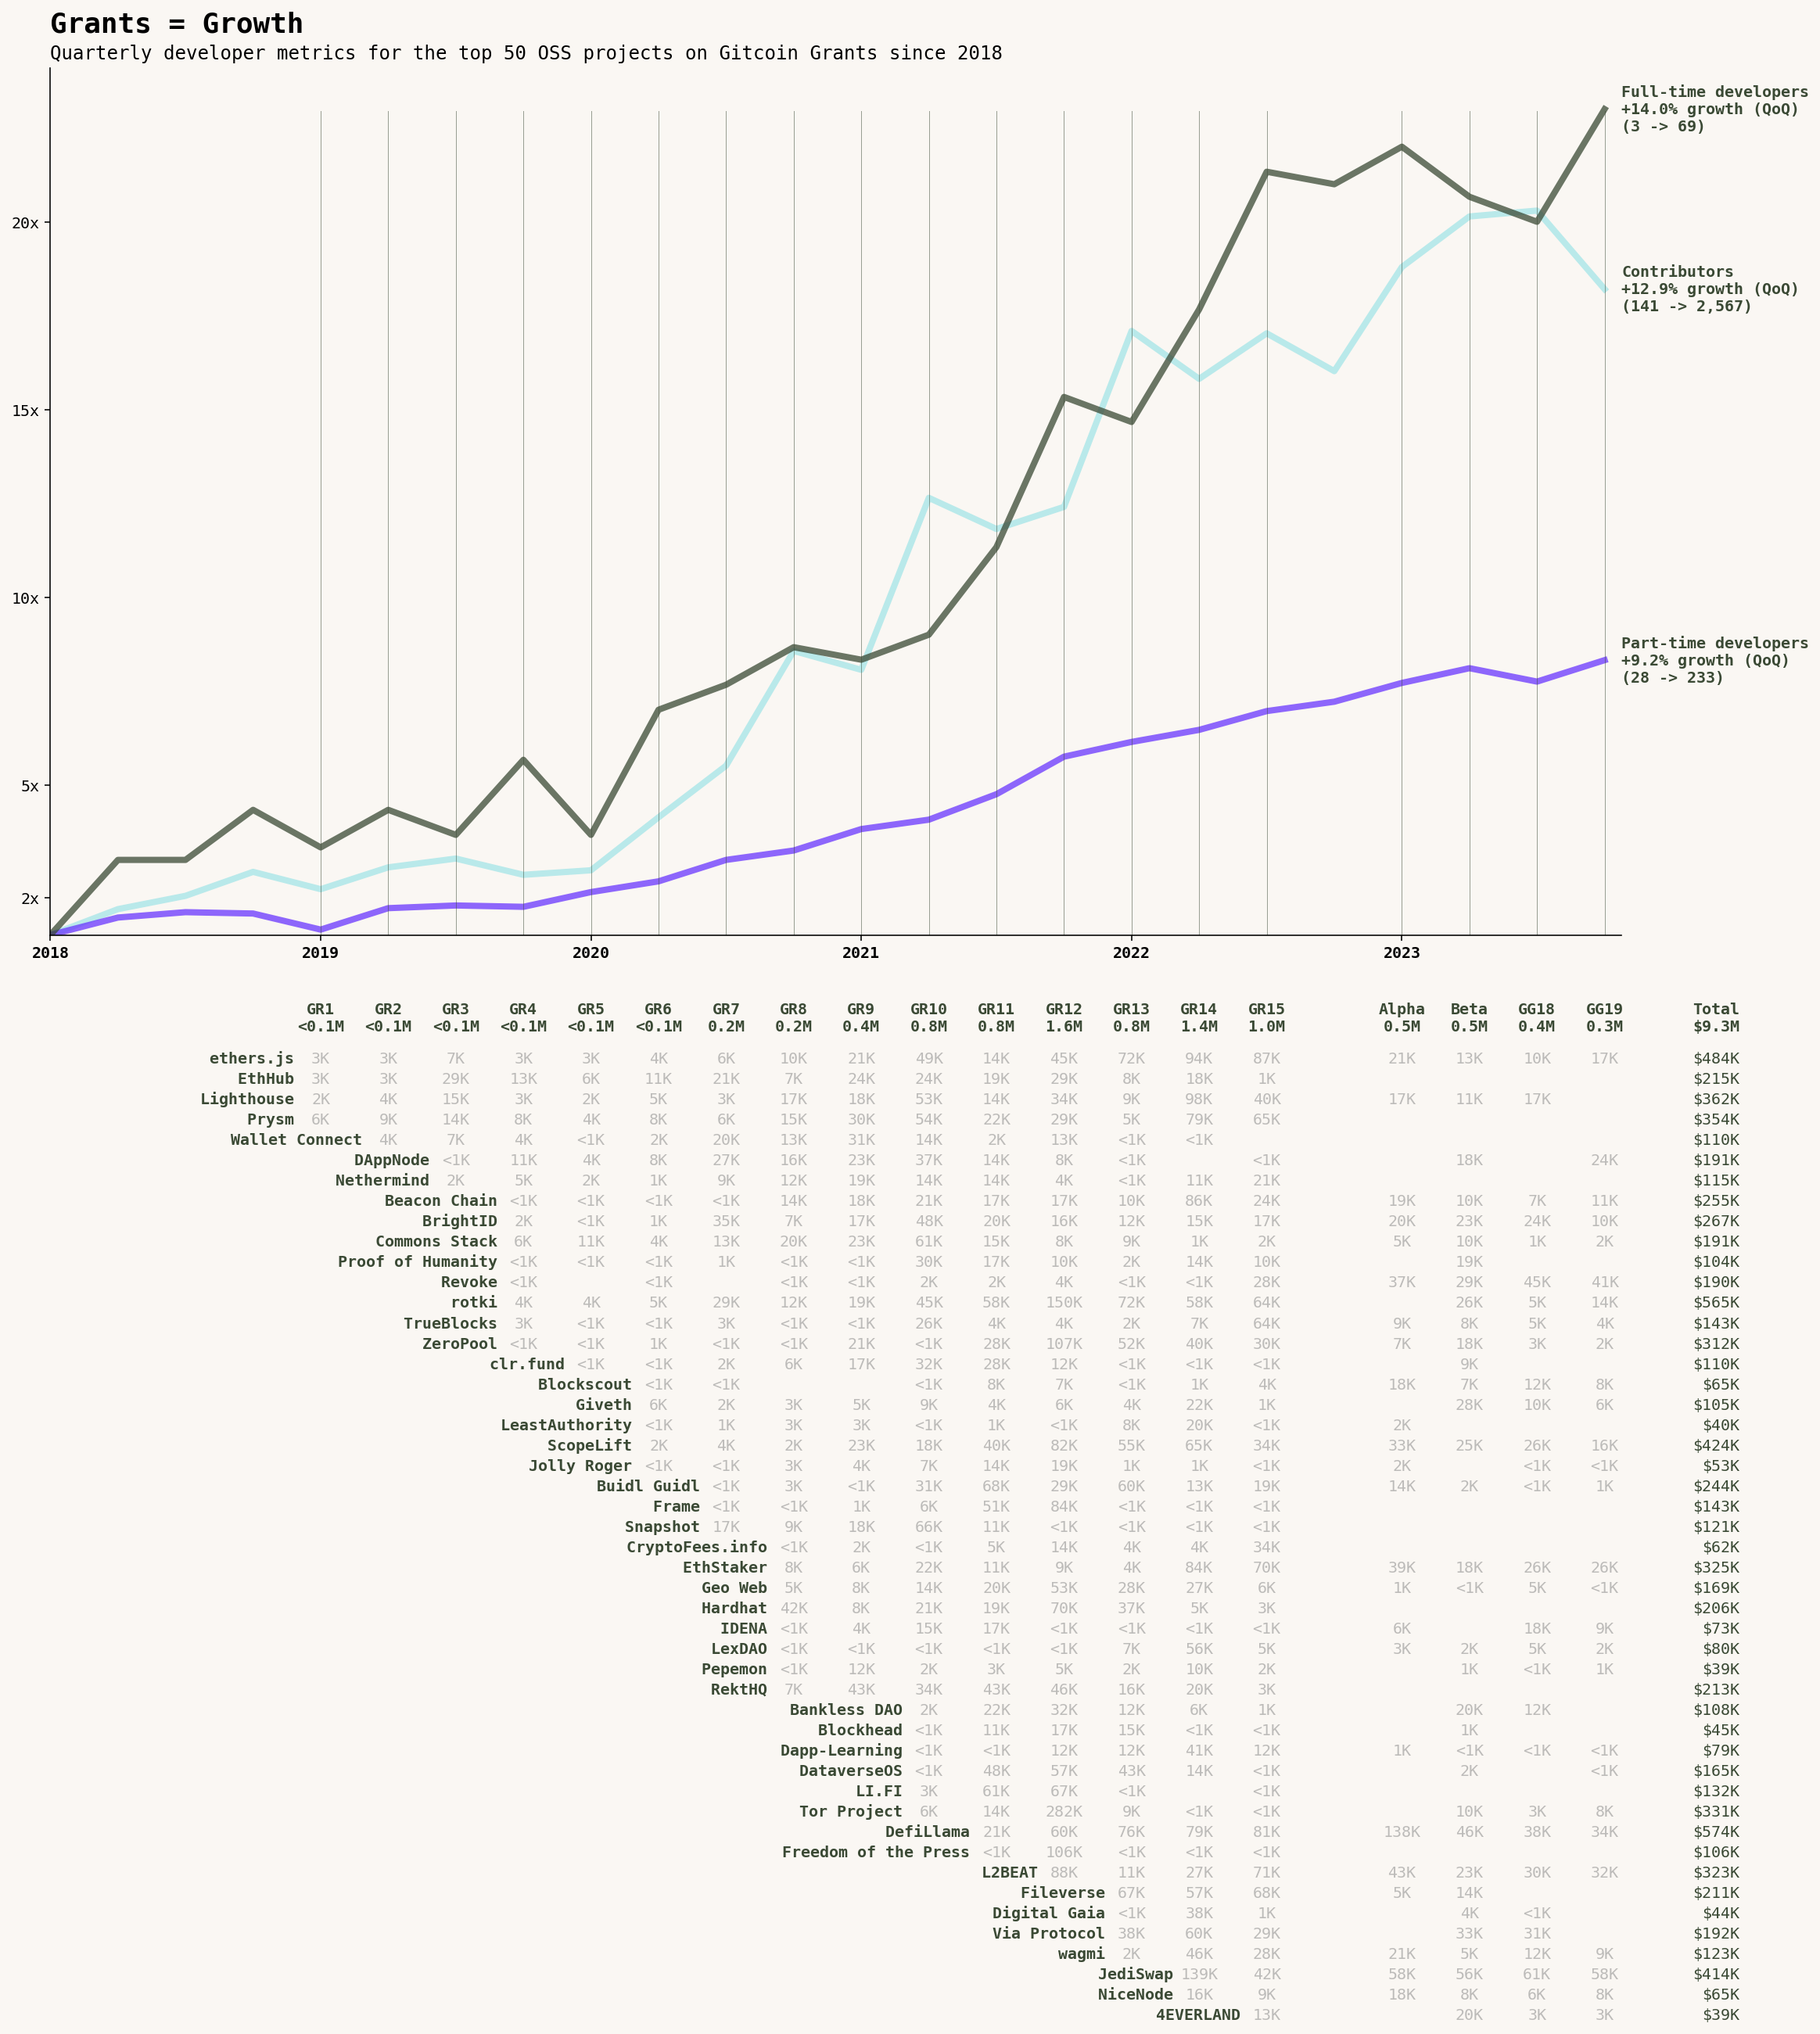

In [15]:
# initialize the plot
fig, ax = plt.subplots(figsize=(18,10), dpi=144, facecolor=WHITE)

start_q, end_q = quarter_mapping.get(START), quarter_mapping.get(END)

def plot_vector(col_name, col_label, color, ax):

    # define the impact vector
    vector = (
        impact
        .groupby('quarter')
        [col_name]
        .sum()
    )
    peak_impact = vector.max()
    scaled_vector = vector/vector[0]
    cagr = round(((vector[-1] / vector[0]) ** (1/len(vector)) - 1)*100,1) 

    # plot the impact metric
    scaled_vector.plot(kind='line', lw=4, color=color, alpha=.75, ax=ax)

    # label the line plot
    ax.text(s="\n".join([
                col_label, 
                f"+{cagr}% growth (QoQ)",
                f"({vector[0]:,.0f} -> {vector[-1]:,.0f})"]), 
            x=end_q+.25, 
            y=scaled_vector[-1], 
            weight='bold', 
            ha='left', 
            va='center', 
            color=GREEN)

# make the lines    
plot_vector('contributors', 'Contributors',"#A3E5E7", ax)
plot_vector('part-time', 'Part-time developers', PURPLE, ax)
plot_vector('full-time', 'Full-time developers', GREEN, ax)
    
# get y axis variables    
ax.set_ylim(1,)
ymax = ax.get_ylim()[1]
ysub = -(ymax * 0.1)
ysub_offset = ymax * .0225

# add vertical lines signifying funding events     
amt_fmt = lambda a: "<0.1M" if a < 100_000 else f"{a/1_000_000:.1f}M"
amt_fmt_k = lambda a: "<1K" if a < 1000 else f"{a/1000:.0f}K"
for i, ((quarter, round_name), amount) in enumerate(grant_stats.items()):
    x = quarter_mapping.get(quarter)
    if not x:
        continue
    ax.axvline(x=x, ymin=0, ymax=.95, color=GREEN, lw=.5, alpha=.5)
    amt = amt_fmt(amount)
    label = f"{round_name}\n{amt}"
    ax.text(s=label, 
            x=x, 
            y=ysub/2, 
            ha='center', 
            va='center', 
            fontsize=SMALL, 
            color=GREEN, 
            weight='bold')
    
    # add project first funding dates
    first_round_projects = projects_first_rounds.get(quarter)
    for y, project_slug in enumerate(ordered_projects_list):
        filtered_grants = grants[grants['quarter'] == quarter]
        included_projects = filtered_grants['oso_slug'].to_list()
        if project_slug not in included_projects:
            continue

        if first_round_projects and project_slug in first_round_projects:
            ax.text(s=f"{project_names[project_slug]} ", 
                    x=x-.25, 
                    y=ysub-(y*ysub_offset), 
                    color=GREEN, 
                    weight='bold', 
                    ha='right')
        
        result = filtered_grants[filtered_grants['oso_slug'] == project_slug]['total_usd'].sum()
        label = amt_fmt_k(result)
        ax.text(s=label, 
                x=x, 
                y=ysub-(y*ysub_offset), 
                color='grey',
                alpha=.5, 
                ha='center')


# add quarter and year tick labels
interval = 4
quarters_list = list(quarter_mapping.keys())    
ax.set_xlim(start_q, end_q+.25)    
xs = list(range(0, len(quarters_list), interval))    
ax.set_xticks(xs) 
ax.set_xticklabels([str(x) for x in range(2018,2024)], weight='bold')

# add summary metrics
ax.text(s=f"Total\n${amt_fmt(grant_stats.sum())}", 
        x=end_q+2, 
        y=ysub/2, 
        weight='bold', 
        ha='right', 
        va='center', 
        color=GREEN)

for y, project_slug in enumerate(ordered_projects_list):
    funding = grants[grants['oso_slug'] == project_slug]['total_usd'].sum()
    ax.text(s=f"${amt_fmt_k(funding)}", x=end_q+2, y=ysub-(y*ysub_offset), ha='right', color=GREEN)

# styling tweaks    
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_yticks([2,5,10,15,20])
ax.set_yticklabels(["2x","5x","10x","15x","20x"])
ax.set_facecolor(WHITE)
ax.text(s='Grants = Growth', x=0, y=ymax*1.04, weight='bold', fontsize=18)
ax.set_title("Quarterly developer metrics for the top 50 OSS projects on Gitcoin Grants since 2018", loc='left')
sns.despine()    